# Neural network

## Imports and custom functions

First, we import libraries, arrays and list we are going to use for this section.

We also redefine a custom function `display_classification_reports_confusion_matrices()` used after GridSearch to display classification report and confusion matrix overall, but also by customer class to assess predictive power for each customer class. `custom_format()` is used to reformat gridsearch results and improve readability.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle

from IPython.display import display
from itertools import cycle
from zipfile import ZipFile
from sklearn.metrics import (accuracy_score,
                             average_precision_score,
                             classification_report,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             f1_score,
                             make_scorer,
                             precision_recall_curve,
                             precision_score,
                             recall_score)
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import activations, initializers, callbacks

sns.set_style('darkgrid')

In [2]:
def display_classification_reports_confusion_matrices(y_pred):
    """
    Takes predictions array as input and display classificaiton report overall and then
    Confusion matrices by customer class (rfm_label) that has been previously one hot encoded
    """
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig.subplots_adjust(wspace=0.8)

    # Plots standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    disp1 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=class_names, ax=ax1)
    disp1.ax_.set_xticklabels(class_names, rotation=90)
    disp1.im_.colorbar.remove()

    # Plots normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    disp2 = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, normalize="true", display_labels=class_names, ax=ax2)
    disp2.ax_.set_xticklabels(class_names, rotation=90)
    disp2.im_.colorbar.remove()

    # Get classification report
    print(classification_report(y_test, y_pred, output_dict=False, zero_division=1))
    
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    # Get precision, recall, f1 from report dict
    precision = round(report['weighted avg']['precision'], 2)
    recall = round(report['weighted avg']['recall'], 2)
    f1 = round(report['weighted avg']['f1-score'], 2)
    
    # Format title
    title_formatted = f"Overall Confusion Matrices\nprecision={precision} recall={recall} f1={f1}"
    
    fig.suptitle(title_formatted, y=1.005)
    plt.show()
    
    # OHE columns matching our rfm_labels
    labels_of_interest = ['rfm_label_Good Customers', 'rfm_label_Low Value Customers', 'rfm_label_VIP']

    # Find column indices corresponding to OHE rfm_label columns
    label_indices = [np.where(columns == label)[0][0] for label in labels_of_interest]

    # Iterate over each OHE rfm_label
    for i, label in enumerate(labels_of_interest):    
        # Find column position of OHE rfm_label
        label_index = label_indices[i]

        # Find unique values in the column of interest and their maximum
        unique_values = np.unique(X_test[:, label_index])
        max_value = np.max(unique_values)

        # Find rows of X_test where OHE rfm_label is true
        rows_of_interest = np.where(X_test[:, label_index] == max_value)
        
        # Select corresponding rows of y_test and y_pred
        y_test_subset = y_test[rows_of_interest]
        y_pred_subset = y_pred[rows_of_interest]

        # Restrict our class_names to only classes in subset
        # VIP can only become 5 values, other 6.
        classes = np.unique(y_test_subset)
        class_names_subset = [class_names[label] for label in classes if label in class_labels]

        fig, axs = plt.subplots(1, 2, figsize=(9, 4))

        # Plots standard confusion matrix
        axs[0].set_title("Confusion Matrix (counts)")
        disp1 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, display_labels=class_names_subset, ax=axs[0])
        disp1.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp1.im_.colorbar.remove()

        # Plots normalized confusion matrix
        axs[1].set_title("Confusion Matrix (ratios)")
        disp2 = ConfusionMatrixDisplay.from_predictions(
            y_test_subset, y_pred_subset, normalize="true", display_labels=class_names_subset, ax=axs[1])
        disp2.ax_.set_xticklabels(class_names_subset, rotation=90)
        disp2.im_.colorbar.remove()

        # Get classification report
        report = classification_report(y_test_subset, y_pred_subset, output_dict=True, zero_division=1)
        # Get precision, recall, f1 from report dict
        precision = round(report['weighted avg']['precision'], 2)
        recall = round(report['weighted avg']['recall'], 2)
        f1 = round(report['weighted avg']['f1-score'], 2)
        # Format title
        title_formatted = f"{label}\nprecision={precision} recall={recall} f1={f1}"
        
        # Set figure title to label of interest
        fig.subplots_adjust(wspace=0.8)
        fig.suptitle(title_formatted, y=1.005)
        plt.show()

In [3]:
def custom_format(value, col_name):
    if col_name.startswith('param_'):
        return value
    elif 'time' in col_name:
        return round(value, 0)
    elif 'mean' in col_name:
        return round(value, 3)
    elif 'std' in col_name:
        return round(value, 4)
    else:
        return value

Now, we load train and test set and also outliers arrays that can be used in outlier removal.

In [4]:
class_labels = [0, 1, 2, 3, 4]
class_names = ['Sleeping Dog', 'Low Value Customers', 'Sleeping Beauty', 'Good Customers', 'VIP']
colors = ['red', 'orange', 'purple', 'blue', 'green']

# Load test set from pickle file
with open('testset.pkl', 'rb') as f:
    testset = pickle.load(f)
X_test, y_test = testset['X_test'], testset['y_test']

# Load train set from pickle file
with open('trainset_base.pkl', 'rb') as f:
    trainset = pickle.load(f)
X_train, y_train = trainset['X_train'], trainset['y_train']

with open('columns.pkl', 'rb') as f:
    columns = pickle.load(f)
    
# Load dictionary containing all outliers array
with open("outliers.pkl", "rb") as f:
    loaded_outliers_dict = pickle.load(f)

In [5]:
X_train_outliers_conservative = loaded_outliers_dict["conservative"]
X_train_outliers_aggressive = loaded_outliers_dict["aggressive"]
X_train_outliers_lof = loaded_outliers_dict["lof"]
X_train_outliers_iforest = loaded_outliers_dict["iforest"]

outlier_dict = {
    "aggressive": X_train_outliers_aggressive,
}

In [6]:
model_file_name = 'DenseNetwork.csv'

We remove outliers using the following as we have seen better performance on other classifier using this method. We don't want to complexify here as neural network is complex enough.

In [7]:
# Remove rows with outliers from X_train and y_train
outlier_mask = X_train_outliers_aggressive
X_train = X_train[outlier_mask != 1]
y_train = y_train[outlier_mask != 1]

Here, we use Robust Scaler to standardize our features before going into gridSearch.

In [8]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Neural Network

Here is our machine learning plan from proposal

## Plan

Model interpretability, suitability, scalability, diversity, …?

- __Flexibility/Scalability__: Neural networks are highly flexible and can model complex, non-linear relationships. We plan on using a neural network with Dense layers, which is a suitable model for multiclass classification problems. It is chosen due to its scalability with respect to the number of layers and neurons, and the ability to learn complex patterns from the input data. We plan on reusing a model close to the dense layer part of course 4 project. 
- __Interpretability__: not the best, it tends to be hard to interprets the relationships between input features and output classes, especially with additional dense layer between input and output.

Methodologies to be used to train and finetune my models?

- Using Keras with the TensorFlow backend to build, train, and fine-tune the model. I will use GridSearchCV to find best hyperparameters for the model with using early stopping to prevent overfitting by stopping the training process when the validation accuracy stops improving.
- Sequential is the Keras model API that allows us to stack layers in a linear manner. The Dense layer is the simplest and most common type of layer, where every input node is connected to every output node with a weight.
- In our case, we only have one output node since we are doing binary classification, and we use the `softmax` activation function to convert output value between 0 and 1.
- We will use as loss function `sparse_categorical_crossentropy` as this is the case of multi-class classification where the output is a probability distribution over multiple classes.

Model Parameters
- __batch_size__ determines the number of samples to be processed in each update during training. 
- __reg_strength__ is the regularization strength for L2 regularization applied to the model's weights. A smaller value means stronger regularization. We will apply regularization in dense layers and try no regularization or stronger values.
- __dropout__ is the fraction of the input units to drop at each update during training. This helps prevent overfitting. We will have dropout tried in dense layers to also try and fight overfitting
- __learning_rate__ controls the step size for the optimizer during training. A higher learning_rate can help to escape local minima, but too high a learning_rate can also prevent convergence.
- __optimizer__, at the start we plan on using Adam optimizer as it performed well on course 4.  
- We plan also to use as variables the __number of neurons__ in the initial layers and in the intermediary layers. I plan also to use potentially different __number of layers__, as part of grid search similar to what is done in this [article](https://datagraphi.com/blog/post/2019/12/17/how-to-find-the-optimum-number-of-hidden-layers-and-nodes-in-a-neural-network-model)

## Adaptations based on observations after running model
We tested

```python
param_grid = {
    'fit__batch_size': [300],
    'model__reg_strength': [0.001],
    'model__dropout': [0.1, 0.15, 0.2],
    'model__learning_rate': [0.001, 0.01],
    'model__first_layer_neurons': [256, 512, 1024],
    'model__additional_layer_neurons': [32, 64, 128],
    'model__n_layers': [1, 2, 3]
}
```

We see better performance meaning a test f1 score close to 5% of the best but with a training score at 62% instead of 88% with
- __dropout__ implemented at 0.1
- __learning_rate__ at 0.001
- __first_layer_neurons__ at high values. We try out different values 1000, 1500, 2000
- __additional_layer_neurons__ performs as well at 64 or 128. We keep 100 as a round value
- __model__n_layers__ : additional layers seem to only increase overfitting greatly at the cost of little greater accuracy on test. We keep with 1 layer

In [9]:
num_features = X_train.shape[1]

def create_model(reg_strength, dropout, learning_rate, first_layer_neurons, additional_layer_neurons, n_layers):
    model = Sequential()
    model.add(Dense(first_layer_neurons, input_shape=(num_features,),
                    activation='relu',
                    kernel_regularizer=keras.regularizers.l2(reg_strength)
                   ))
    
    # Add additional Dense and Dropout layers based on n_layers
    for _ in range(n_layers - 1):
        model.add(Dense(additional_layer_neurons, activation='relu',
                        kernel_regularizer=keras.regularizers.l2(reg_strength)
                       ))
        model.add(Dropout(dropout))
    
    model.add(Dense(5,
                    activation='softmax',
                    kernel_regularizer=keras.regularizers.l2(reg_strength)
                   ))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                 )
    return model

model = KerasClassifier(
    model=create_model,
    reg_strength=None,
    dropout=None,
    learning_rate=None,
    first_layer_neurons=None,
    additional_layer_neurons=None,
    n_layers=None,
    verbose=0
)

# Define grid of hyperparameters to search
param_grid = {
    'fit__batch_size': [300],
    'model__reg_strength': [0.001, 0.005],
    'model__dropout': [0.1, 0.15],
    'model__learning_rate': [0.001, 0.005],
    'model__first_layer_neurons': [1000, 1500, 2000],
    'model__additional_layer_neurons': [100],
    'model__n_layers': [1]
}

early_stop = EarlyStopping(monitor='val_loss', patience=10)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=6,
    cv=3,
    verbose=1,
    return_train_score=True,
    scoring={
        'f1': make_scorer(f1_score, average='weighted'),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted')
    },
    refit='f1'  
)

# Start timer
start_time = time.time()

# Fit model with early stopping
grid_search.fit(
    X_train,
    y_train,
    validation_split=0.3,
    epochs=100,
    callbacks=[early_stop]
)

# End timer
end_time = time.time()
elapsed_time = end_time - start_time

# Print time taken to fit the model
print("Time taken to fit the model: {:.2f} seconds".format(elapsed_time))

# Print the best hyperparameters and accuracy
print(f'Best score: {grid_search.best_score_}, Best params: {grid_search.best_params_}')

# Evaluation on test data
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Accuracy on unseen test data:: {:.2f}%".format(test_score * 100))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Time taken to fit the model: 1651.03 seconds
Best score: 0.541922136479831, Best params: {'fit__batch_size': 300, 'model__additional_layer_neurons': 100, 'model__dropout': 0.1, 'model__first_layer_neurons': 2000, 'model__learning_rate': 0.001, 'model__n_layers': 1, 'model__reg_strength': 0.001}
Accuracy on unseen test data:: 55.84%


In [10]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_f1", ascending=False)

file_path = os.path.join('gs_results', model_file_name)
cv_results.to_csv(file_path, index=False)

# Get columns starting with 'param_'
param_columns = [col for col in cv_results.columns if col.startswith('param_')]

# Create a list of desired column names
desired_columns = [
    'mean_fit_time',
    'mean_test_f1', 'mean_train_f1',
    *param_columns, 
    'std_test_f1', 'std_train_f1',
    'mean_test_precision', 'mean_train_precision',
    'std_test_precision', 'std_train_precision',
    'mean_test_recall', 'mean_train_recall',
    'std_test_recall', 'std_train_recall',    
]

# Apply custom formatting function and select columns
cv_results = cv_results.apply(lambda col: col.apply(lambda value: custom_format(value, col.name)))
cv_results = cv_results[desired_columns]
cv_results.head(10)

,mean_fit_time,mean_test_f1,mean_train_f1,param_fit__batch_size,param_model__additional_layer_neurons,param_model__dropout,param_model__first_layer_neurons,param_model__learning_rate,param_model__n_layers,param_model__reg_strength,std_test_f1,std_train_f1,mean_test_precision,mean_train_precision,std_test_precision,std_train_precision,mean_test_recall,mean_train_recall,std_test_recall,std_train_recall
8,165.0,0.542,0.602,300,100,0.10,2000,0.001,1,0.001,0.0017,0.0013,0.541,0.602,0.0030,0.0013,0.548,0.607,0.0017,0.0015
20,153.0,0.541,0.601,300,100,0.15,2000,0.001,1,0.001,0.0024,0.0036,0.540,0.603,0.0026,0.0054,0.550,0.608,0.0017,0.0031
16,116.0,0.541,0.602,300,100,0.15,1500,0.001,1,0.001,0.0007,0.0031,0.544,0.607,0.0004,0.0021,0.550,0.610,0.0024,0.0025
12,92.0,0.540,0.600,300,100,0.15,1000,0.001,1,0.001,0.0036,0.0016,0.540,0.602,0.0052,0.0022,0.549,0.608,0.0019,0.0018
4,111.0,0.538,0.598,300,100,0.10,1500,0.001,1,0.001,0.0018,0.0060,0.537,0.599,0.0015,0.0048,0.549,0.607,0.0022,0.0035
0,86.0,0.538,0.598,300,100,0.10,1000,0.001,1,0.001,0.0016,0.0058,0.544,0.606,0.0045,0.0045,0.542,0.602,0.0014,0.0040
14,80.0,0.525,0.546,300,100,0.15,1000,0.005,1,0.001,0.0059,0.0065,0.529,0.552,0.0084,0.0074,0.534,0.555,0.0029,0.0007
22,157.0,0.524,0.543,300,100,0.15,2000,0.005,1,0.001,0.0051,0.0043,0.524,0.544,0.0033,0.0028,0.534,0.553,0.0010,0.0017
6,132.0,0.523,0.542,300,100,0.10,1500,0.005,1,0.001,0.0021,0.0019,0.524,0.543,0.0021,0.0010,0.535,0.554,0.0026,0.0009
2,105.0,0.520,0.541,300,100,0.10,1000,0.005,1,0.001,0.0044,0.0050,0.521,0.543,0.0040,0.0063,0.533,0.553,0.0007,0.0026


## Best model by Epoch

Here, we retrain our best model (based on weighted f1 score on validation data) so we can see epoch by epoch was is happening. It is also a cool way to show how overfitting evolves overtime. 

In [11]:
best_params = grid_search.best_params_
model = create_model(
    best_params['model__reg_strength'],
    best_params['model__dropout'],
    best_params['model__learning_rate'],
    best_params['model__first_layer_neurons'],
    best_params['model__additional_layer_neurons'],
    best_params['model__n_layers']
)


history = model.fit(
    X_train, y_train,
    validation_split=0.3,
    epochs=100,
    batch_size=best_params['fit__batch_size'],
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
142/142 [==============================] - 1s 6ms/step - loss: 1.2933 - accuracy: 0.4881 - val_loss: 1.2105 - val_accuracy: 0.5047
Epoch 2/100
142/142 [==============================] - 1s 6ms/step - loss: 1.1694 - accuracy: 0.5212 - val_loss: 1.1621 - val_accuracy: 0.5200
Epoch 3/100
142/142 [==============================] - 1s 5ms/step - loss: 1.1368 - accuracy: 0.5283 - val_loss: 1.1422 - val_accuracy: 0.5205
Epoch 4/100
142/142 [==============================] - 1s 6ms/step - loss: 1.1206 - accuracy: 0.5367 - val_loss: 1.1369 - val_accuracy: 0.5257
Epoch 5/100
142/142 [==============================] - 1s 6ms/step - loss: 1.1088 - accuracy: 0.5396 - val_loss: 1.1326 - val_accuracy: 0.5261
Epoch 6/100
142/142 [==============================] - 1s 5ms/step - loss: 1.1029 - accuracy: 0.5446 - val_loss: 1.1387 - val_accuracy: 0.5166
Epoch 7/100
142/142 [==============================] - 1s 6ms/step - loss: 1.0993 - accuracy: 0.5470 - val_loss: 1.1186 - val_accuracy: 0.5359

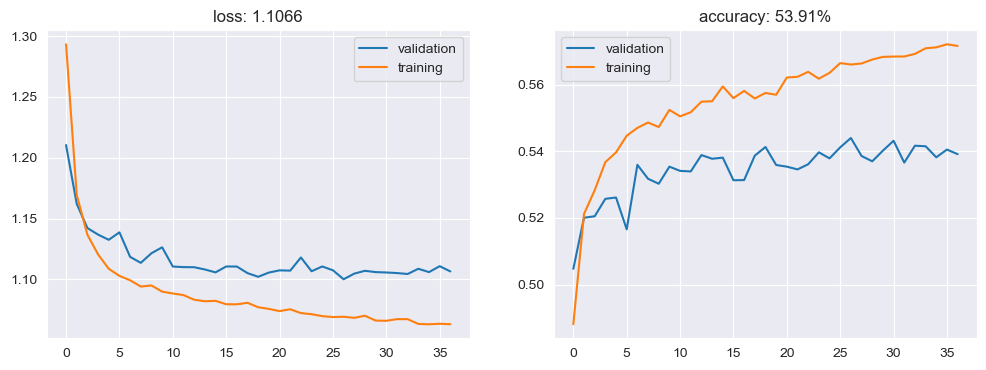

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title("loss: {:.4f}".format(history.history["val_loss"][-1]))
ax1.plot(history.history["val_loss"], label="validation")
ax1.plot(history.history["loss"], label="training")
ax1.legend()

# plot accuracy values
ax2.set_title("accuracy: {:.2f}%".format(history.history["val_accuracy"][-1] * 100))
ax2.plot(history.history["val_accuracy"], label="validation")
ax2.plot(history.history["accuracy"], label="training")
ax2.legend()

plt.show()

## Results

### Classification report and Confusion matrices

We use our custom function to display confusion matrix and classications reports. Note that we don't extensively comment results here as they are from best model on validation f1 weighted score and we might end up chosing a different model with a better trade off between validation f1 weighted score and overfitting. We will do this in our results notebook, where we compile results from all our model.

              precision    recall  f1-score   support

           0       0.60      0.88      0.71      7803
           1       0.49      0.49      0.49      7823
           2       0.47      0.30      0.37      7800
           3       0.46      0.43      0.45      7740
           4       0.73      0.68      0.70      7834

    accuracy                           0.56     39000
   macro avg       0.55      0.56      0.54     39000
weighted avg       0.55      0.56      0.54     39000



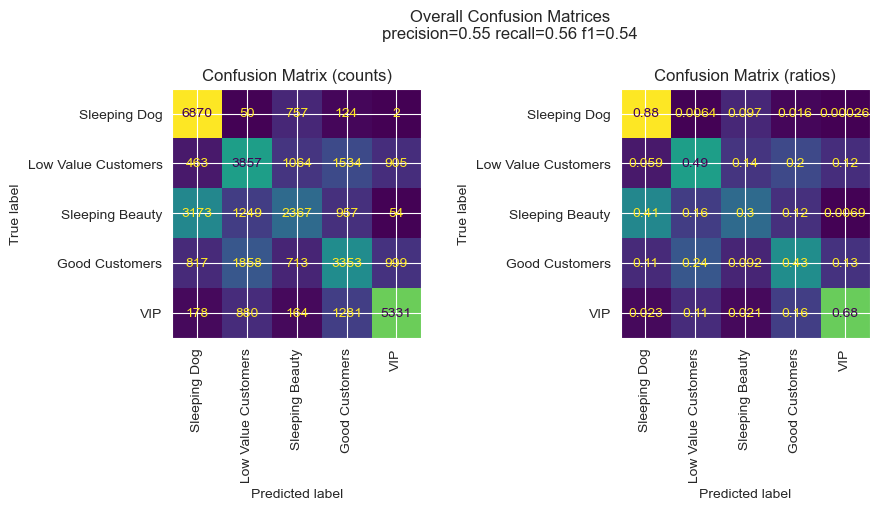

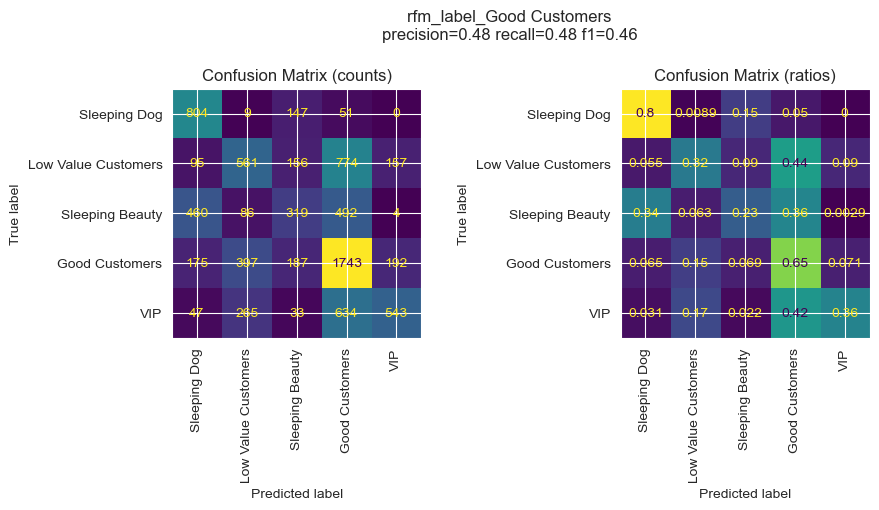

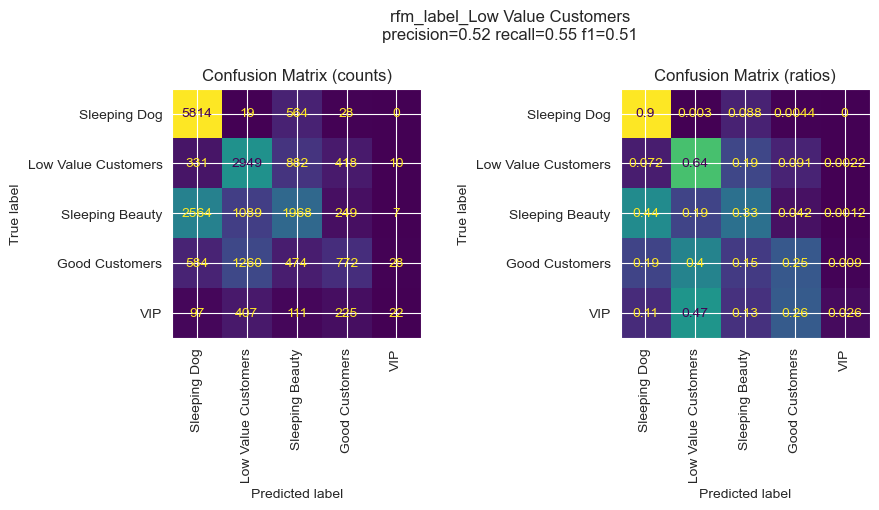

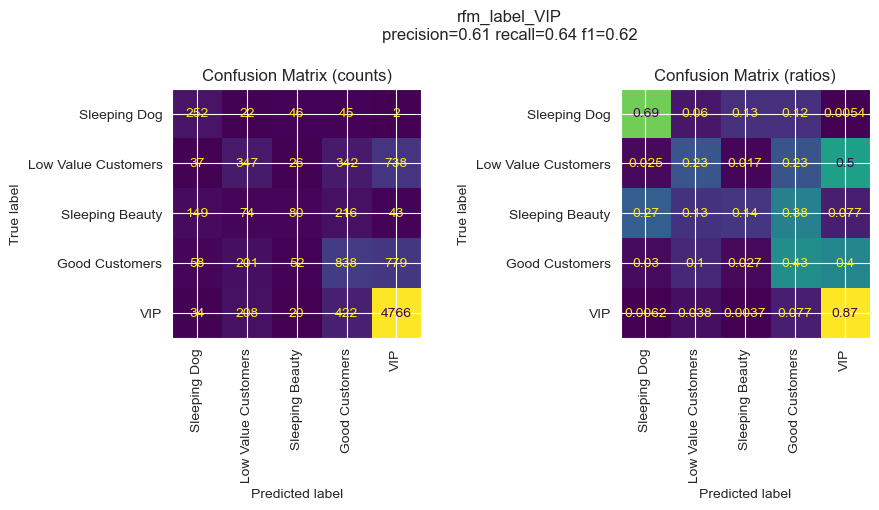

In [13]:
y_pred = best_model.predict(X_test)

display_classification_reports_confusion_matrices(y_pred)